In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
%config Completer.use_jedi = False

## Librerias

In [33]:
# random search forecaster
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from skforecast.model_selection.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

## Data

Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


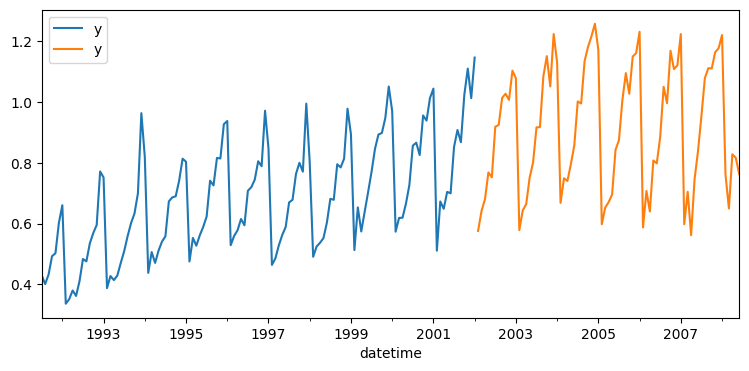

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [9]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

In [30]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-12 12:04:11 
Last fit date: 2022-10-12 12:04:11 
Skforecast version: 0.6.0.dev 
Python version: 3.9.13 

In [31]:
forecaster.window_size

15

In [32]:
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['y'],
                                   initial_train_size = 15,
                                   steps              = 12,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   fixed_train_size   = False,
                                   verbose            = False
                               )

ValueError: The maximum lag (15) must be less than the length of the series (15).

In [22]:
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['y'],
                                   initial_train_size = len(data.loc[:end_train]),
                                   steps              = 1,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   fixed_train_size   = False,
                                   verbose            = False
                               )

The forecaster will be fit 77 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



In [26]:
forecaster = ForecasterAutoregDirect(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 2,
                 steps     = 12
             )

metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['y'],
                                   initial_train_size = len(data['y']) - 24,
                                   steps              = 12,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   fixed_train_size   = False,
                                   verbose            = False
                               )

metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['y'],
                                   initial_train_size = len(data.loc[:end_train]),
                                   steps              = 1,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   fixed_train_size   = False,
                                   verbose            = False
                               )

The forecaster will be fit 924 times (77 folds * 12 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`. 



In [37]:
import re
import pytest

lags_list = [1, 1.5, [1, 2], range(5)]
lags_np_array = np.array([1.2, 1.5])
err_msg = re.escape('Values in `lags` must be int.')

for lags in [lags_list, lags_np_array]:
    with pytest.raises(TypeError, match = err_msg):
        ForecasterAutoregMultiSeries(RandomForestRegressor(), lags=lags)

In [41]:
forecaster = ForecasterAutoregDirect(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = [1.5, 2],
                 steps     = 12
             )

TypeError: All values in lags must be int.